In [3]:
!git clone https://github.com/moaaztaha/Image-Captioning/
py_files_path = 'Image-Captioning/'
import sys
sys.path.append(py_files_path)

In [4]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from utils import load_checkpoint
from dataset import build_vocab, get_loaders
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
from utils import print_scores

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# !mkdir /root/.kaggle
# !mv kaggle.json /root/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json

!pip install kaggle -q
!kaggle datasets download -d aladdinpersson/flickr8kimagescaptions
!unzip -q flickr8kimagescaptions.zip

 99% 1.02G/1.04G [00:12<00:00, 113MB/s]
100% 1.04G/1.04G [00:12<00:00, 89.6MB/s]


In [8]:
# data pathes
DATA_JSON_PATH = '/content/Image-Captioning/data.json'
IMGS_PATH = '/content/flickr8k/images'
CHECKPOINT_PATH = '/content/drive/MyDrive/ImageCaptioning/flickr8/BEST_checkpoint_flickr8k_finetune.pth.tar'

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print("Device:", device)

Device: cuda


In [10]:
# Load model
checkpoint = load_checkpoint(CHECKPOINT_PATH)
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval();

Loaded Checkpoint!!
Last Epoch: 12
Best Bleu-4: 15.97917426288958


In [11]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [12]:
vocab = build_vocab(DATA_JSON_PATH)
len(vocab)

100%|██████████| 40000/40000 [00:00<00:00, 291269.59it/s]


5089

In [14]:
bs = 1
beam_size=3
loader = get_loaders(bs, IMGS_PATH, DATA_JSON_PATH, transform, vocab, test=True, n_workers=8)

Dataset split: test
Unique images: 1000
Total size: 5000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [69]:
import matplotlib.pyplot as plt

# import skimage.transform
# import argparse
from PIL import Image
def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    image = transform(img).to(device)  # (3, 256, 256)

    plt.imshow(img)
    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map.stoi['<sos>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words // vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)
        
        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)
#         print(seqs[prev_word_inds], prev_word_inds)
#         if step == 5:
#             return seqs
        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map.stoi['<eos>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    print(complete_seqs_scores)
    print(seq)

    return seq, alphas, complete_seqs, i

[tensor(-11.7479, device='cuda:0', grad_fn=<UnbindBackward>), tensor(-12.3075, device='cuda:0', grad_fn=<UnbindBackward>), tensor(-15.1955, device='cuda:0', grad_fn=<UnbindBackward>)]
[1, 4, 164, 19, 112, 167, 104, 34, 4, 264, 2]


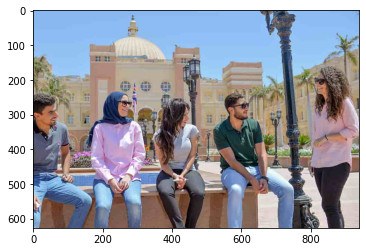

In [77]:
seq, _, comp_seqs, idx = caption_image_beam_search(encoder, decoder, '/content/adm-now-bann-min.png', vocab, beam_size=beam_size)

In [78]:
comp_seqs

[[1, 4, 164, 19, 112, 167, 104, 34, 4, 264, 2],
 [1, 4, 164, 19, 112, 167, 104, 34, 4, 373, 2],
 [1, 4, 164, 19, 112, 167, 104, 34, 4, 264, 11, 57, 19, 4, 181, 2]]

In [79]:
addit_tokens = [vocab.stoi['<sos>'], vocab.stoi['<eos>'], vocab.stoi['<pad>']]

In [80]:
[" ".join([vocab.itos[i] for i in sent if i not in addit_tokens]) for sent in comp_seqs]

['a group of people are sitting on a bench',
 'a group of people are sitting on a sidewalk',
 'a group of people are sitting on a bench in front of a building']

In [81]:
[" ".join([vocab.itos[i] for i in seq if i not in addit_tokens])]

['a group of people are sitting on a bench']

In [82]:
idx

0